# Instalación de librerías

Instalamos las librerías necesarias para el trabajo con modelos de lenguaje (Transformers), procesamiento de datos (Pandas, Numpy) y deep learning (PyTorch).

In [31]:
!pip -q install transformers datasets torch numpy

In [32]:
import os, json, random, datetime, numpy as np, pandas as pd
import torch, torch.nn as nn
from torch.utils.data import DataLoader
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          get_linear_schedule_with_warmup)
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             confusion_matrix, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Definición de rutas y parámetros globales

Establecemos las rutas a los archivos de datos, así como parámetros globales para reproducibilidad, configuración del modelo y el entorno de entrenamiento.

In [34]:
root_dir   = '/content/drive/MyDrive/PDG/data/'
export_dir = '/content/drive/MyDrive/PDG/models/'
os.makedirs(export_dir, exist_ok=True)

path_train_aug = root_dir + "train_oversample_df.xlsx"
path_val_aug   = root_dir + "val_df.xlsx"
path_base      = root_dir + "base_df.xlsx"
path_test      = root_dir + "test_df.xlsx"

In [35]:
SEED       = 42
BATCH      = 8
EPOCHS     = 15
LR         = 2e-5
THRESHOLD  = 0.30
model_name = "PlanTL-GOB-ES/roberta-base-biomedical-clinical-es"
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [36]:
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False

# Preparación del Tokenizer

Descargamos y preparamos el tokenizer preentrenado de RoBERTa biomédico en español, fundamental para convertir los textos en secuencias de tokens.

In [37]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

Dataset y DataLoader auxiliares

# Definición del Dataset y DataLoader

Definimos una clase auxiliar de PyTorch para convertir textos y etiquetas en tensores adecuados para el entrenamiento del modelo Transformer.

In [38]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tok, max_len=128):
        enc = tok(texts, truncation=True, padding='max_length',
                  max_length=max_len, return_tensors='pt')
        self.ids   = enc['input_ids']
        self.mask  = enc['attention_mask']
        self.lbls  = torch.tensor(labels)

    def __len__(self): return len(self.lbls)
    def __getitem__(self, i):
        return {"input_ids": self.ids[i],
                "attention_mask": self.mask[i],
                "labels": self.lbls[i]}

# Función para crear DataLoaders

Creamos una función auxiliar que permite generar los DataLoaders para los conjuntos de entrenamiento, validación y test de forma sencilla y uniforme.

In [39]:
def make_loaders(df_train, df_val, df_test, tok):
    ds_tr = TextDataset(df_train.texto.tolist(), df_train.label.tolist(), tok)
    ds_va = TextDataset(df_val.texto.tolist(),   df_val.label.tolist(), tok)
    label_col = 'label' if 'label' in df_test.columns else 'etiqueta'
    ds_te = TextDataset(df_test.texto.tolist(), df_test[label_col].tolist(), tok)
    return (DataLoader(ds_tr, batch_size=BATCH, shuffle=True),
            DataLoader(ds_va, batch_size=BATCH),
            DataLoader(ds_te, batch_size=BATCH))

# Funciones auxiliares para el entrenamiento y evaluación

Incluimos funciones para calcular los pesos de clase (importante en casos de desbalanceo), para reportar las métricas de desempeño y graficar la matriz de confusión, y para exportar el modelo y el tokenizer entrenados.

In [40]:
def class_wts(labels):
    w = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    return torch.tensor(w, dtype=torch.float)

In [41]:
def metrics_report(model, loader, thr, tag):
    model.eval(); p, y = [], []
    with torch.no_grad():
        for b in loader:
            ids  = b['input_ids'].to(device)
            msk  = b['attention_mask'].to(device)
            lbls = b['labels'].to(device)
            probs = torch.softmax(model(ids, attention_mask=msk).logits, 1)[:, 1]
            p.extend((probs >= thr).long().cpu().numpy())
            y.extend(lbls.cpu().numpy())
    acc  = accuracy_score(y, p)
    prec, rec, f1, _ = precision_recall_fscore_support(y, p, average='binary')
    print(f"\n📊 {tag}  Acc:{acc:.4f}  Prec:{prec:.4f}  Rec:{rec:.4f}  F1:{f1:.4f}")
    cm = confusion_matrix(y, p)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["No crítico", "Crítico"]
    )
    disp.plot(cmap="Blues")
    plt.title(f"CM – {tag}")
    plt.show()

In [42]:
def export_model(model, tok, out_dir, thr):
    model.save_pretrained(out_dir + "/model")
    tok.save_pretrained(out_dir + "/tokenizer")
    meta = {
        "threshold": thr,
        "date": datetime.datetime.now().isoformat(),
        "torch": torch.__version__,
        "transformers": __import__('transformers').__version__
    }
    with open(out_dir + "/meta.json", "w") as fp: json.dump(meta, fp, indent=2)
    print(f"✅ Exportado en: {out_dir}")

# Carga de datasets

Cargamos los distintos conjuntos de datos:

* Datos aumentados (entrenamiento y validación)
* Base original (para comparar contra el modelo aumentado)
* Test final (para la tercera validación y prueba final de desempeño)
  Convertimos la columna de etiquetas en una columna `label` para uniformidad.

In [43]:
df_train_aug = pd.read_excel(path_train_aug); df_val_aug = pd.read_excel(path_val_aug)
for d in (df_train_aug, df_val_aug): d["label"] = d["etiqueta"]

In [44]:
df_base = pd.read_excel(path_base)
df_base["label"] = df_base["etiqueta"]
df_base_tr, df_base_val = train_test_split(
    df_base, test_size=0.20, stratify=df_base.label, random_state=SEED
)

In [45]:
df_test = pd.read_excel(path_test)
df_test["label"] = df_test["etiqueta"]

# Función principal de entrenamiento y validación

Definimos una función que entrena el modelo sobre el set de entrenamiento, evalúa su desempeño en el set de validación y en el set de test final, y exporta el modelo y el tokenizer entrenados. Así centralizamos todo el proceso en un solo paso.

In [46]:
def train_model(tag, df_tr, df_val, df_test):
    print(f"\n══════════  {tag.upper()}  ══════════")
    train_loader, val_loader, test_loader = make_loaders(df_tr, df_val, df_test, tokenizer)

    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
    weights = class_wts(df_tr.label.values).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, 0, len(train_loader)*EPOCHS
    )

    model.train()
    for ep in range(EPOCHS):
        ep_loss = 0
        for batch in train_loader:
            ids  = batch['input_ids'].to(device)
            msk  = batch['attention_mask'].to(device)
            lbls = batch['labels'].to(device)

            optimizer.zero_grad()
            loss = criterion(model(ids, attention_mask=msk).logits, lbls)
            loss.backward(); optimizer.step(); scheduler.step()
            ep_loss += loss.item()
        print(f"Ep {ep+1:02}/{EPOCHS}  Loss:{ep_loss/len(train_loader):.4f}")

    # Evaluación en validación
    metrics_report(model, val_loader, THRESHOLD, f"{tag.upper()}-VAL")

    # Evaluación en test final (tercera validación)
    metrics_report(model, test_loader, THRESHOLD, f"{tag.upper()}-TEST_FINAL")

    out = os.path.join(export_dir, f"roberta_{tag}")
    os.makedirs(out, exist_ok=True)
    export_model(model, tokenizer, out, THRESHOLD)
    return model

# Entrenamiento y evaluación de modelos

Entrenamos y evaluamos dos modelos:

* Uno sobre datos aumentados (mayor balance entre clases y potencial de generalización)
* Otro sobre los datos originales (para comparar el impacto del aumento de datos)
  Ambos modelos se evalúan en el set de validación y en el set de test final para comparar su rendimiento real sobre datos no vistos.


══════════  AUG  ══════════


pytorch_model.bin:   0%|          | 0.00/504M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/504M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-biomedical-clinical-es and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Ep 01/15  Loss:0.2295
Ep 02/15  Loss:0.1152
Ep 03/15  Loss:0.0667
Ep 04/15  Loss:0.0507
Ep 05/15  Loss:0.0219
Ep 06/15  Loss:0.0232
Ep 07/15  Loss:0.0112
Ep 08/15  Loss:0.0039
Ep 09/15  Loss:0.0026
Ep 10/15  Loss:0.0037
Ep 11/15  Loss:0.0043
Ep 12/15  Loss:0.0018
Ep 13/15  Loss:0.0011
Ep 14/15  Loss:0.0003
Ep 15/15  Loss:0.0003

📊 AUG-VAL  Acc:0.9256  Prec:0.7863  Rec:0.8306  F1:0.8078


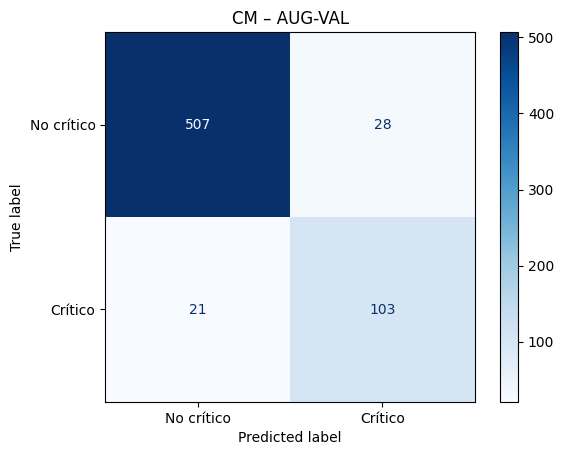


📊 AUG-TEST_FINAL  Acc:0.9000  Prec:0.7143  Rec:0.7895  F1:0.7500


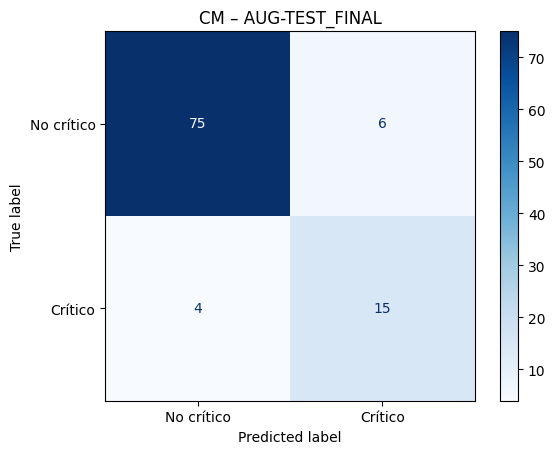

✅ Exportado en: /content/drive/MyDrive/PDG/models/roberta_aug


In [47]:
model_aug  = train_model("aug",  df_train_aug, df_val_aug, df_test)


En la validación (AUG-VAL), el modelo alcanzó una exactitud (accuracy) de 0.93, con una precisión (precision) de 0.79, un recall (sensibilidad) de 0.83 y un F1-score de 0.81. Estos valores indican que el modelo es bastante efectivo identificando correctamente los casos críticos durante la validación, manteniendo un buen equilibrio entre la cantidad de verdaderos positivos identificados y la cantidad de falsos positivos generados.

En la prueba final sobre el conjunto de test (AUG-TEST_FINAL), las métricas muestran un ligero descenso, con una accuracy de 0.90, precisión de 0.71, recall de 0.79 y F1-score de 0.75. Esto es esperado, ya que el test contiene ejemplos completamente nuevos para el modelo. Sin embargo, el rendimiento sigue siendo aceptable y demuestra una adecuada capacidad de generalización.

En general aunque las métricas son un poco menores en el test final respecto a la validación, el modelo mantiene un desempeño sólido en ambos conjuntos, especialmente en recall, lo cual es crucial en aplicaciones clínicas donde es fundamental identificar la mayoría de los casos críticos.


══════════  BASE  ══════════


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-biomedical-clinical-es and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Ep 01/15  Loss:0.3874
Ep 02/15  Loss:0.2320
Ep 03/15  Loss:0.1700
Ep 04/15  Loss:0.1219
Ep 05/15  Loss:0.0827
Ep 06/15  Loss:0.0724
Ep 07/15  Loss:0.0368
Ep 08/15  Loss:0.0229
Ep 09/15  Loss:0.0256
Ep 10/15  Loss:0.0260
Ep 11/15  Loss:0.0149
Ep 12/15  Loss:0.0124
Ep 13/15  Loss:0.0126
Ep 14/15  Loss:0.0136
Ep 15/15  Loss:0.0108

📊 BASE-VAL  Acc:0.9393  Prec:0.8500  Rec:0.8226  F1:0.8361


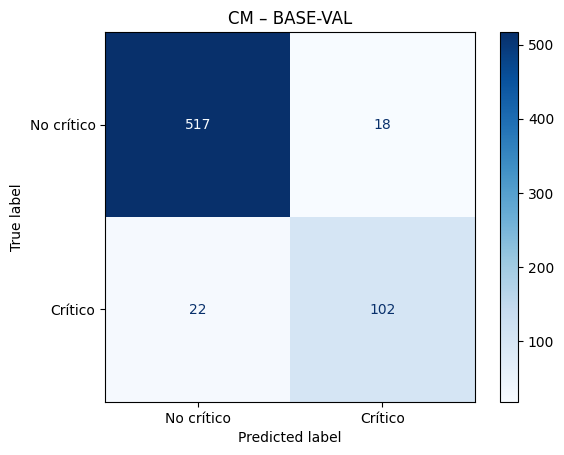


📊 BASE-TEST_FINAL  Acc:0.9000  Prec:0.7368  Rec:0.7368  F1:0.7368


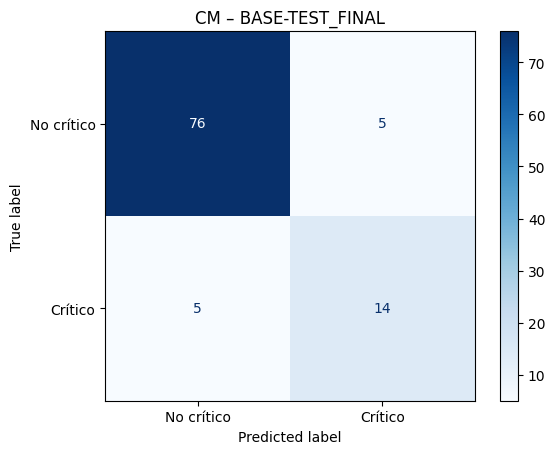

✅ Exportado en: /content/drive/MyDrive/PDG/models/roberta_base


In [48]:
model_base = train_model("base", df_base_tr,  df_base_val, df_test)



* **Desempeño en Validación (BASE-VAL):**

  * El modelo obtiene una **exactitud (accuracy) de 0.94**, lo que indica que casi todas las predicciones en el conjunto de validación fueron correctas.
  * La **precisión (precision) es de 0.85**, es decir, el 85% de los casos que el modelo identificó como "críticos" realmente lo eran.
  * El **recall (sensibilidad) es de 0.82**, lo que significa que el modelo identificó correctamente el 82% de todos los informes realmente críticos.
  * El **F1-score es de 0.84**, mostrando un buen equilibrio entre precisión y recall.

* **Desempeño en Test Final (BASE-TEST\_FINAL):**

  * En el conjunto de prueba final, la **exactitud baja a 0.90**, lo que sigue siendo un valor alto.
  * La **precisión y el recall caen a 0.74**, mostrando que el modelo es menos efectivo cuando se enfrenta a datos completamente nuevos. El **F1-score** también refleja esta disminución, ubicándose en 0.74.
  * Esta bajada es común y esperada, ya que el conjunto de test contiene ejemplos no vistos durante el entrenamiento y validación, probando la capacidad de generalización real del modelo.
